## **Boosting Marketing Efficiency: Targeted Bank Campaign by Customer Subscription Behavior**

**Overall Project Objective:** 

Develop a data-driven marketing strategy that maximizes return on investment (ROI) by identifying optimal trade-off between broad customer outreach and precision marketing using predictive modeling.

**Notebook 3 of 3: Feature Importance & Business Impact Analysis**

This notebook dives deeper into our final model and derive business insight that fulfills our overall project objective.

### **Setup & Data Load**

Libraries, the final model, and the test data load.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load the trained model (random forest) 
file_path = '../models/tuned_rf_mod.joblib'
tuned_rf_mod = joblib.load(file_path)
# load the scaler (for partial dependence plot)
scaler = joblib.load('../models/scaler.joblib')

**-Data Overview-**

Only the test data files ('X_test_scaled', 'y_test') will be used in this notebook. 

In [3]:
# load the test data
X_test_scaled = pd.read_csv('../data/X_test_scaled.csv') # scaled test data
X_test_original = pd.read_csv('../data/X_test_original.csv') # original, unscaled test data
y_test = pd.read_csv('../data/y_test.csv').squeeze() # target test data

print("Test set shape: ", X_test_scaled.shape)

Test set shape:  (905, 37)


### **Feature Importance Analysis**

To understand why our model makes its predictions, we will begin by analyzing its feature importances. This analysis will reveal which customer attributes and campaign variables are the most powerful predictors of whether a client will subcribe. The result will be visualized using a horizontal bar plot to highlight the top 15 most influential predictors. 

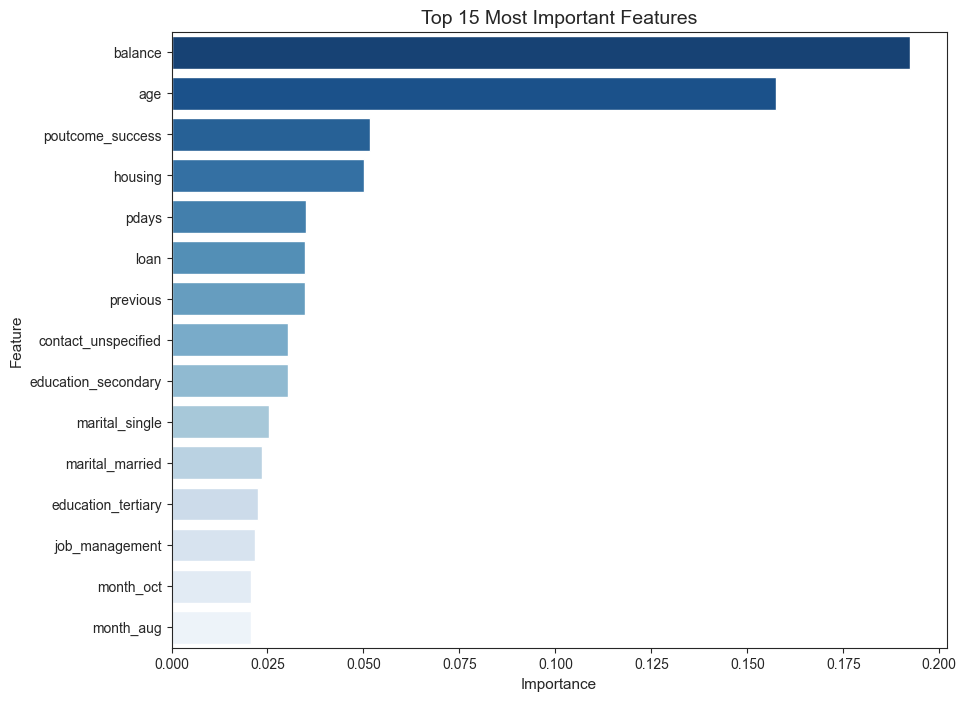

In [4]:
importance = tuned_rf_mod.feature_importances_
feature_importances = pd.Series(importance, index=X_test_scaled.columns)

top_15_features = feature_importances.sort_values(ascending=False).head(15)

sns.set_style('ticks')
plt.figure(figsize=(10,8))
sns.barplot(x=top_15_features.values, 
            y=top_15_features.index,
            hue=top_15_features.index,
            legend=False,
            palette='Blues_r')

plt.title("Top 15 Most Important Features", fontsize=14)
plt.xlabel("Importance", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.show()

The feature importance analysis reveals that our model's predictions are driven by four key themes, providing a clear picture of the ideal customer profile. 
1. **Financial Profile:** A client's financial situation is the most dominant factor. 'Balance' is the single most important feature, followed by existing obligations such as 'housing' and 'loan.' This strongly suggests that clients with higher financial capacity and fewer debts are the primary target audience.

2. **Previous Campaign Interactions:** A client's history with the bank is highly predictive. A previous success ('poutcome_success') is the strongest indicator in this group, followed closely by the recency of the last contact ('pdays'). This proves that re-engaging with previously successful or recently contacted clients is a highly effective strategy. 

3. **Client Demographics:** While many demographic features are important, a client's 'age' is by far the most influential, reinforcing the idea that life stage is critical factor.

4. **Campaign Execution:** The analysis also validates our feature engineering, with 'contact_unspecified" ranking as a top-10 predictor. This confirms that the lack of known contact method is a significant piece of information. Seasonal factors like the month of contact also contribute to the model's predictions.

Building on these findings, the next section will examine these key themes in greater detail using partial dependence plots to further refine our business strategy.

**Deeper Dive: The Financial Profile**

Given that financial variables dominate the feature importance list, this section will focus on the single most influential predictor: a client's account 'balance.' By examining how the model's predictions change with different 'balance' levels, we can translate this key insight into a more effective marketing and targeting strategy.

To visualize the effect of account 'balance' on the model's prediction, we will generate a partial dependence plot. The plot is created using the scaled data that the model was trained on, which allows us to accurately see the shape and trend of the relationship.

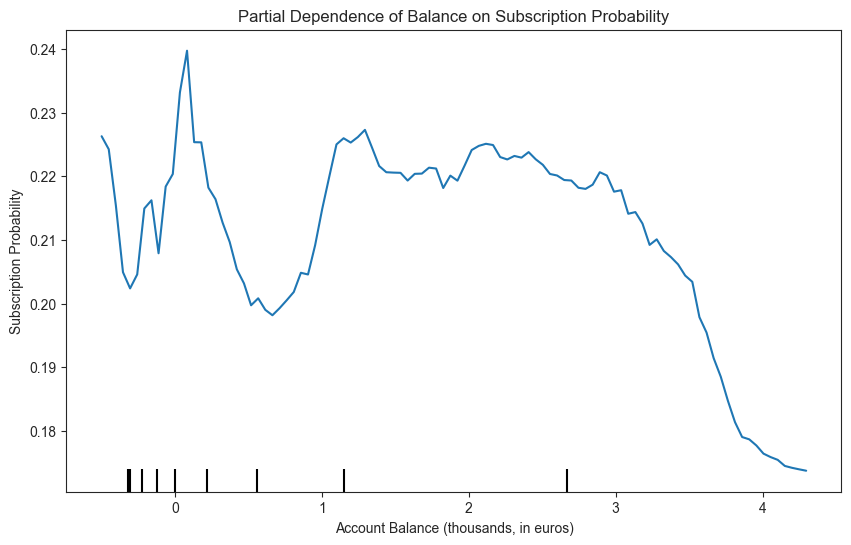

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=tuned_rf_mod,
    X=X_test_scaled,
    features=['balance'],
    ax=ax
)

ax = pdp_display.axes_[0,0]
ax.set(title="Partial Dependence of Balance on Subscription Probability",
       xlabel="Account Balance (thousands, in euros)",
       ylabel="Subscription Probability")
plt.show()

*To make the plot's x-axis easily interpretable in real-world terms, the following lookup table translates the key scaled values back to their original account balances in Euros. This allows us to connect the key points on the plot directly to meaningful business insights.*

In [6]:
print("--- Scaled Value to Balance Lookup Table ---\n")
num_cols = ['age','balance','pdays','previous']
balance_index = num_cols.index('balance')
balance_median = scaler.center_[balance_index]
balance_iqr = scaler.scale_[balance_index]

scaled_values_check = [-1, 0, 1, 2, 3, 4]
for scaled_val in scaled_values_check:
    original_balance = (scaled_val * balance_iqr) + balance_median
    print(f"A scaled value of {scaled_val:2} corresponds to a balance of around € {int(original_balance):8,.2f}")

--- Scaled Value to Balance Lookup Table ---

A scaled value of -1 corresponds to a balance of around €  -939.00
A scaled value of  0 corresponds to a balance of around €   444.00
A scaled value of  1 corresponds to a balance of around € 1,827.00
A scaled value of  2 corresponds to a balance of around € 3,211.00
A scaled value of  3 corresponds to a balance of around € 4,594.00
A scaled value of  4 corresponds to a balance of around € 5,978.00


The partial dependence plot for 'balance' reveals a complex, non-linear relationship with subscription probability, suggesting four distinct customer segments. 

1. **The Financially Stretched:** This group represents the highest peak in subscription probability. Counter-intuitively, these are clients with a negative or a very low positive balance (up to approx. €400). This suggests they may be actively seeking structured savings products to achieve financial stability, making them **highly recpetive audience.** 

2. **The Cautious Saver:** Following the initial peak, subscription probability dips significantly. This segment consists of clients with a balance between roughly €500 and €1,800. They may be more risk-averse, representing either a **lower-priority target or a different kind of marketing opportunity.**

3. **The Mass Affluent:** This group forms the second, broader peak, with a consistently high subscription probability for clients with balances between €1,800 and €3,200. As a stable, high-value segment with disposable income, they are a **prime target for marketing efforts.**

4. **The High Net Worth:** Finally, for clients with balances above approximately €3,200, **subscription probability steadily declines.** This suggests these clients have access to more sophisticated investment options, making a term deposit less appealing.

**Deeper Dive: The Role of Client Demographics**

Client demographics are a significant factor in our model, accounting for 6 of the top 15 most important features. Among these, a client's 'age' is the most influential demographic predictor. This section will focus specifically on the 'age' variable. By examining how it influences the model's predictions, we can derive actionable business insights for more effective customer targeting.

To visualize how 'age' influences model's prediction, we will generate another partial dependence plot.

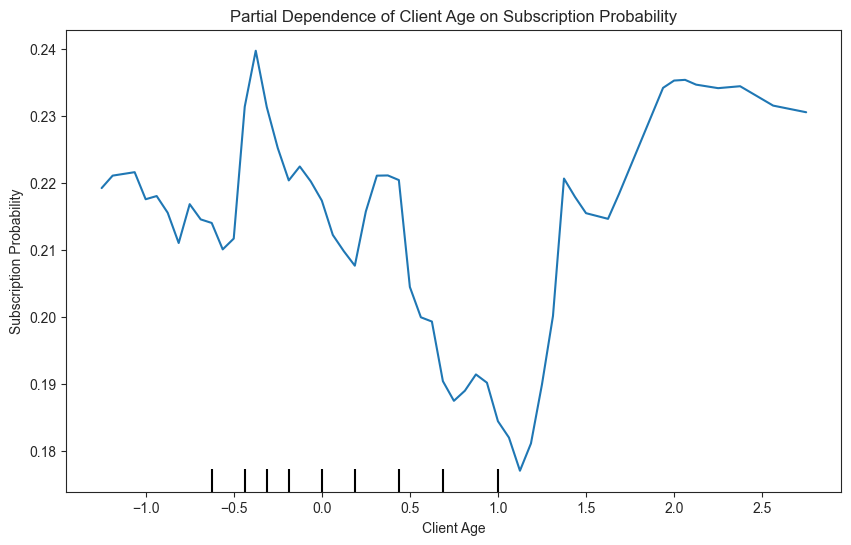

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=tuned_rf_mod,
    X=X_test_scaled,
    features=['age'],
    ax=ax
)

ax = pdp_display.axes_[0,0]
ax.set(title="Partial Dependence of Client Age on Subscription Probability",
       xlabel="Client Age",
       ylabel="Subscription Probability")
plt.show()

*To make the plot's x-axis easily interpretable in real-world terms, the following lookup table translates the key scaled values back to their original ages. This allows us to connect the key points on the plot directly to meaningful business insights.*

In [8]:
print("--- Scaled Value to Age Lookup Table ---\n")
age_index = num_cols.index('age')
age_median = scaler.center_[age_index]
age_iqr = scaler.scale_[age_index]

scaled_values_check = [-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
for scaled_val in scaled_values_check:
    original_age = (scaled_val * age_iqr) + age_median
    print(f"A scaled value of {scaled_val:4.1f} corresponds to an age of around {int(original_age)}")

--- Scaled Value to Age Lookup Table ---

A scaled value of -1.0 corresponds to an age of around 23
A scaled value of -0.5 corresponds to an age of around 31
A scaled value of  0.0 corresponds to an age of around 39
A scaled value of  0.5 corresponds to an age of around 47
A scaled value of  1.0 corresponds to an age of around 55
A scaled value of  1.5 corresponds to an age of around 63
A scaled value of  2.0 corresponds to an age of around 71
A scaled value of  2.5 corresponds to an age of around 79


The partial dependence plot for 'age' reveals a distinct, non-linear U-shaped relationship with subscription probability, highlighting three key life-stage segments:

1. The Younger Professional (Under 35): Subscription probability is high for this segment. This suggests that younger clients are a key demographic, likely because they are at a life stage focues on establishing foundational savings habits, making term deposit an attractive first product.

2. The Middel-Aged Squeeze (Age 39 - 55): The probability reaches its lowest point in this range. This is likely due to peak family and financial responsibilities (e.g., raising children, mortgages), leaving less disposable income for this type of savings product.

3. The Pre-Retired & Retired (Over 55): After age 55, subscription probability rises sharply and remains high. This segment is likely shifting its focus to capital preservation and stable, low-risk investments, making term deposits a highly attractive option.

This provides a clear strategic directive: marketing efforts can be most effective when targeting at the youngest and oldest customer segments. 

**Deeper Dive: Exposure to Previous Campaign**

Our model identified the outcome of previous campaign, specifically 'poutcome_success,' as the most influential categorical feature. This section analyzes this relationship to quantify the opportunity and derive a clear, high-priority target segment for future marketing efforts.

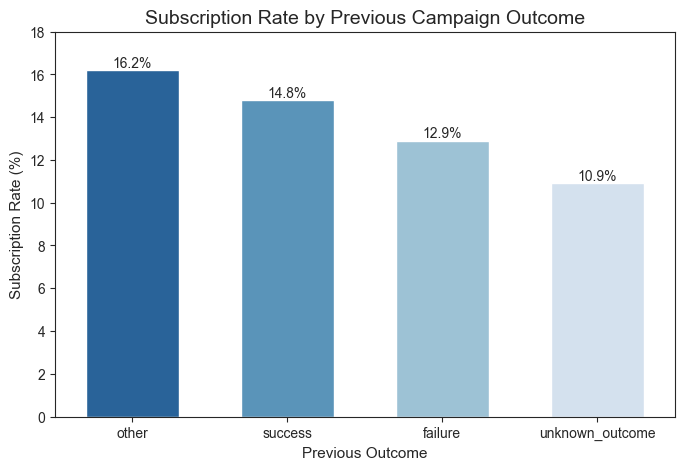

In [9]:
# load cleaned original data (before one-hot encoding)
df_cleaned = pd.read_csv('../data/bank_cleaned.csv')
# combine feature variables and a target variable
temp_df = X_test_original.copy()
temp_df['y'] = y_test
# convert 1 and 0 back to yes and no
binary_values = {1:'yes', 0:'no'}
temp_df['y'] = temp_df['y'].map(binary_values)
# use original cleaned data which has 'poutcome_missing' variable
temp_df['poutcome'] = df_cleaned.loc[temp_df.index, 'poutcome']

poutcome_rate = temp_df.groupby('poutcome')['y'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)*100
poutcome_rate = poutcome_rate.round(1)

sns.set_style('ticks')
plt.figure(figsize=(8,5))
ax = sns.barplot(x=poutcome_rate.index,
                 y=poutcome_rate['yes'],
                 hue=poutcome_rate.index,
                 legend=False,
                 palette='Blues_r',
                 width=.6)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center',
                va='bottom')
    
plt.title('Subscription Rate by Previous Campaign Outcome', fontsize=14)
plt.xlabel('Previous Outcome', fontsize=11)
plt.ylabel('Subscription Rate (%)', fontsize=11)
plt.ylim(0,18)
plt.show()

A notable discrepancy was observed in the 'poutcome_success' subgroup. While this group had a ~64% subscription rate in the overall dataset, the rate in our 20% test set was only 14.8%. This significant differences is likely due to sampling variability. Because the 'poutcome_success' group contains very few clients, the random assignment of just a few subscribers to the training or test set can introduce higher volatility in subscripition rate for a small subgroup.

To investigate the potential sampling variability, the next plot will visualize the client distribution based on their past campaign experience, segmented by their final subscription status.

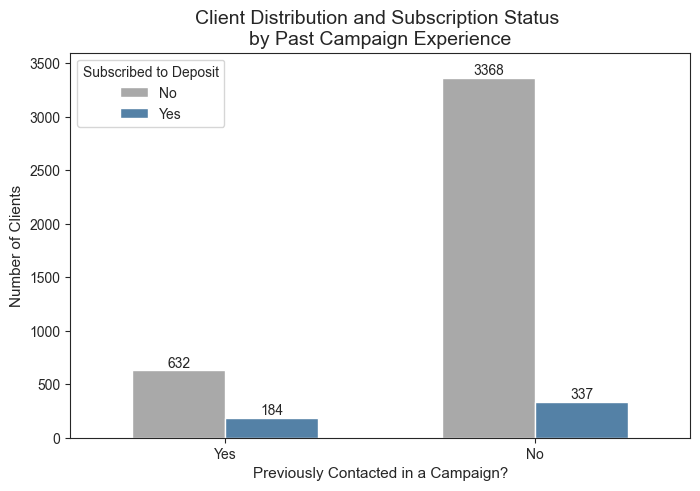

In [10]:
df_cleaned['past_experience'] = df_cleaned['pdays'].apply(lambda x: 'No' if x == -1 else 'Yes')
df_cleaned['Subscribed'] = df_cleaned['y'].str.capitalize()

sns.set_style('ticks')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='past_experience',
                   data=df_cleaned,
                   hue='Subscribed',
                   palette={'No': 'darkgray', 'Yes': 'steelblue'},
                   order=['Yes', 'No'],
                   hue_order=['No', 'Yes'],
                   width=.6)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center',
                    va='bottom')

plt.title('Client Distribution and Subscription Status \nby Past Campaign Experience', fontsize=14)
plt.xlabel('Previously Contacted in a Campaign?', fontsize=11)
plt.ylabel('Number of Clients', fontsize=11)
plt.legend(title='Subscribed to Deposit', loc='upper left')
plt.ylim(0,3600)
plt.show()

This plot confirms our hypothesis regarding sampling variability. The group of clients with past campaign experience is significantly smaller than the group without (816 vs. 3705). Crucially, the number of successful subscribers from this experienced group is only 184, confirming the small sample size that caused the rate discrepancy we noted earlier.

Beyond this statistical validation, these numbers reveal a core strategic dilemma. While clients who have subscribed in the past are high-probability leads, they are also a scarce resource. This raises a key business question for future campaigns: Should our strategy focus on maximizing conversions from this small, high-value segment, or on cost-effectively acquiring new subscribers from the much larger, untapped pool of clients?

This is the trade-off between precision (targeting only the most likely subscribers to maximize ROI) and recall (capturing as many potential subscribers as possible). Our predictive model provides the data-driven framework to answer this question. The next section, the **Precision-Recall Trade-Off Analysis,** will explore this balance to recommend an optimal marketing strategy.

### **Precision-Recall Trade-Off Analysis**

This final section translates our model's performance into a concrete business strategy. We will analyze the trade-off between precision and recall to recommend an optimal approach for the bank's marketing campaign.

**1. The Business Problem**

To select the best model, we must first define our strategic goals. The two key performance metrics, precision and recall, are in direct opposition, and each represents a different business strategy.

*Precision (ROI-Focused)*

- It answers the question: "Of all the customers our model tells us to call, what percentage will actually subscribe?"
- The business goal is to maximize **return on investment (ROI).** A high-precision strategy minimizes spending on clients who are unlikely to subscribe, making the campaign highly efficient.

*Recall (Growth-Focused)*

- It answers the question: "Of all the customers who would have subscribed, what percentage did our model tell us to call?"
- The business goal is to maximize **market reach.**  A high-recall strategy aims to capture the largest possible pool of potential subscribers, minimizng missed opportunities.

*The Trade-Off*

- A highly precise campaign will be very selective and will inevitably miss some potential customers. A high-recall campaign will capture more of these customers but will waste more resources on uninterested leads.

The goal of our analysis is to find the optimal balance between these two objectives.

**2. The Precision-Recall Curve**

To visualize the full spectrum of possible trade-offs our model can offer, we will genearte a precision-recall curve. This curve will illustrate the model's precision for every possible recall value that will allow us to select a specific classification threshold for a chosen busineess strategy. 

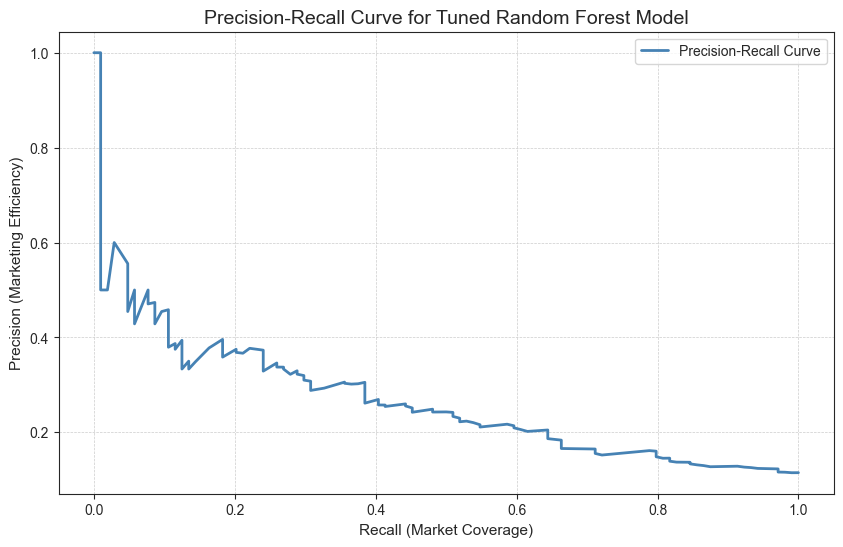

In [11]:
prob_rf_tuned = tuned_rf_mod.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, prob_rf_tuned)

plt.figure(figsize=(10,6))
plt.plot(recall, precision, color='steelblue', linewidth=2, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve for Tuned Random Forest Model', fontsize=14)
plt.xlabel('Recall (Market Coverage)', fontsize=11)
plt.ylabel('Precision (Marketing Efficiency)', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=.5)
plt.legend()
plt.show()

The curve above shows the entire trade-offs our model can offer. Each point on the blue line represents a different balance between precision (marketing efficiency) and recall (market coverage), achieved by adjusting the model's classification threshold. 

To turn this into an actionable business strategy, we will select three representative points from this curve to model distinct scenarios:
- A High-Precision Strategy (focus on ROI)
- A High-Recall Strategy (focus on market reach)
- A Balanced Strategy

**3. Business Scenarios**

*For the following scenario based analyses, we will use a conservative set of business assumptions: an estimated **€5 cost per call** and an estimated **€50 in value** from a successful subscription.*

***A High-Precision Strategy***

The goal of this strategy is to maximize marketing ROI by targeting only the highest-probability leads. To model this, we will set a **target precision of 40%** which represents a significant improvement over both the model's default precision (33.8%) and the campaign's baseline success rate (11.5%).

By selecting the corresponding point on the precision-recall curve, we can determine the resulting recall and analyze the business impact. 

In [12]:
# cost assumptions 
cost_per_call = 5
value_per_sub = 50

pr_df = pd.DataFrame({
    'precision': precision[:-1],
    'recall': recall[:-1],
    'threshold': thresholds
})

In [13]:
# high-precision scenario
high_precision_scenario = pr_df[pr_df['precision'] >= .4].iloc[0]

high_precision_threshold = high_precision_scenario['threshold']
precision_at_threshold_hp = high_precision_scenario['precision']
recall_at_threshold_hp = high_precision_scenario['recall']

tot_sub = y_test.sum()

predictions_at_threshold_hp = (prob_rf_tuned >= high_precision_threshold)
num_to_call_hp = predictions_at_threshold_hp.sum()

marketing_cost_hp = num_to_call_hp * cost_per_call
sub_captured_hp = round(recall_at_threshold_hp * tot_sub)
revenue_hp = sub_captured_hp * value_per_sub
roi_hp = (revenue_hp - marketing_cost_hp) / marketing_cost_hp * 100

print("--- High-Precision Strategy ( >= 40% Precision) ---\n")
print(f"Decision threshold: {high_precision_threshold:.2f}")
print(f"Precision at this threshold: {precision_at_threshold_hp:.1%}")
print(f"Recall at this threshold: {recall_at_threshold_hp:.1%}")
print('-'*42)
print(f"Number of clients to call: {num_to_call_hp} out of {len(y_test)}")
print(f"Subscribers captured: {sub_captured_hp} out of {tot_sub}")
print('-'*42)
print(f"Revenue generated: €{revenue_hp:,.2f}")
print(f"Marketing cost: €{marketing_cost_hp:,.2f}")
print(f"Return on investment (ROI): {roi_hp:.1f}%")

--- High-Precision Strategy ( >= 40% Precision) ---

Decision threshold: 0.74
Precision at this threshold: 40.7%
Recall at this threshold: 10.6%
------------------------------------------
Number of clients to call: 27 out of 905
Subscribers captured: 11 out of 104
------------------------------------------
Revenue generated: €550.00
Marketing cost: €135.00
Return on investment (ROI): 307.4%


The High-Precision strategy demonstartes the model's power to create a hyper-targeted and highly efficient campaign. By focusing on the most probable leads, it allows the bank to **capture 11 subscribers from an exceptionally small list of just 27 calls.**

However, this high efficiency comes at a price. With a **recall of only 10.6%,** this strategy **leaves almost 90% of potential subscribers on the table,** failing to contact the vast majority of likely customers.

- This result suggests that it is an ideal strategy for a campaign with a constrained budget where minimizing marketing waste is the top priority.

***A High-Recall Strategy***

This strategy prioritizes maximizing market reach to capture the largest possible pool of potential subscribers, accepting a lower marketing efficiency as the trade-off. To model this growth-focused approach, we will set a **hypothetical recall target of 75%.** 

This will allow us to analyze the business impact of a strategy that values broad outreach over targeted campaign.

In [14]:
# high-recall scenario
high_recall_scenario = pr_df[pr_df['recall'] >= .75].iloc[-1]

high_recall_threshold = high_recall_scenario['threshold']
precision_at_threshold_hr = high_recall_scenario['precision']
recall_at_threshold_hr = high_recall_scenario['recall']

predictions_at_threshold_hr = (prob_rf_tuned >= high_recall_threshold)
num_to_call_hr = predictions_at_threshold_hr.sum()

marketing_cost_hr = num_to_call_hr * cost_per_call
sub_captured_hr = round(recall_at_threshold_hr * tot_sub)
revenue_hr = sub_captured_hr * value_per_sub
roi_hr = (revenue_hr - marketing_cost_hr) / marketing_cost_hr * 100

print("--- High-Recall Strategy ( >= 75% Recall) ---\n")
print(f"Decision threshold: {high_recall_threshold:.2f}")
print(f"Precision at this threshold: {precision_at_threshold_hr:.1%}")
print(f"Recall at this threshold: {recall_at_threshold_hr:.1%}")
print('-'*42)
print(f"Number of clients to call: {num_to_call_hr} out of {len(y_test)}")
print(f"Subscribers captured: {sub_captured_hr} out of {tot_sub}")
print('-'*42)
print(f"Revenue generated: €{revenue_hr:,.2f}")
print(f"Marketing cost: €{marketing_cost_hr:,.2f}")
print(f"Return on investment (ROI): {roi_hr:.1f}%")

--- High-Recall Strategy ( >= 75% Recall) ---

Decision threshold: 0.12
Precision at this threshold: 16.1%
Recall at this threshold: 78.8%
------------------------------------------
Number of clients to call: 508 out of 905
Subscribers captured: 82 out of 104
------------------------------------------
Revenue generated: €4,100.00
Marketing cost: €2,540.00
Return on investment (ROI): 61.4%


The High-Recall strategy is highly effective at maximizing market coverage. By calling **508 clients,** this approach successfully captures **82 subscribers,** which represents **78.8% of all potential subscribers** in the test set.

However, this wide reach comes at a significant cost to efficiency. With a **precision of only 16.1%,** the campaign must make aporoximately **6 calls to secure one new subscription,** resulting in a much lower ROI than the precision-focused strategy.

- This strategy is best suited for a bank whose primary goal is to aggresively expand its market share. It is ideal for growth phase where aquiring a large valume of new customers is prioritized over short-term marketing efficiency.

***A Balanced Strategy***

This strategy seeks a middle ground, aiming for a healthy balance between marketing efficiency and market reach. To identify the optimal point, we will select the classification threshold that yields the **maximum F1-Score,** a metric designed to find the harmonic mean of precision and recall. 

In [15]:
# f1-score
f1_score = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
max_f1_score = np.argmax(f1_score)

balanced_threshold = thresholds[max_f1_score]
precision_at_f1 = precision[max_f1_score]
recall_at_f1 = recall[max_f1_score]

predictions_at_threshold_bal = (prob_rf_tuned >= balanced_threshold)
num_to_call_bal = predictions_at_threshold_bal.sum()

marketing_cost_bal = num_to_call_bal * cost_per_call
sub_captured_bal = round(recall_at_f1 * tot_sub)
revenue_bal = sub_captured_bal * value_per_sub
roi_bal = (revenue_bal - marketing_cost_bal) / marketing_cost_bal * 100

print("--- Balanced Strategy ---\n")
print(f"Decision threshold: {balanced_threshold:.2f}")
print(f"Precision at this threshold: {precision_at_f1:.1%}")
print(f"Recall at this threshold: {recall_at_f1:.1%}")
print('-'*42)
print(f"Number of clients to call: {num_to_call_bal} out of {len(y_test)}")
print(f"Subscribers captured: {sub_captured_bal} out of {tot_sub}")
print('-'*42)
print(f"Revenue generated: €{revenue_bal:,.2f}")
print(f"Marketing cost: €{marketing_cost_bal:,.2f}")
print(f"Return on investment (ROI): {roi_bal:.1f}%")


--- Balanced Strategy ---

Decision threshold: 0.41
Precision at this threshold: 30.5%
Recall at this threshold: 38.5%
------------------------------------------
Number of clients to call: 131 out of 905
Subscribers captured: 40 out of 104
------------------------------------------
Revenue generated: €2,000.00
Marketing cost: €655.00
Return on investment (ROI): 205.3%


The Balanced Strategy presents a data-driven 'middle ground' between the two extremes. with a **recall of 38.5%** and a **precision of 30.5%,** this approach allows the bank to capture nearly **40% of all potential subscribers.** At the same time, it maintains good efficiency, ensuring that approximately **one in every three calls** is made to an interested client.

- This strategy is ideal for a standard campaign where the goal is to achieve both significant market coverage and strong financial efficiency. It provides a defensible balance, ensuring a healthy number of new customers are acquired without an excessive marketing spend. 

**4. Final Recommendation**

In [16]:
summary_data = {
    'Strategy': ['A: High-Precision', 'B: High-Recall', 'C: Balanced'],
    'Precision': [precision_at_threshold_hp*100, precision_at_threshold_hr*100, precision_at_f1*100],
    'Recall': [recall_at_threshold_hp*100, recall_at_threshold_hr*100, recall_at_f1*100],
    'Clients to Call': [num_to_call_hp, num_to_call_hr, num_to_call_bal],
    'Subscribers Captured': [sub_captured_hp, sub_captured_hr, sub_captured_bal],
    'Marketing Cost': [marketing_cost_hp, marketing_cost_hr, marketing_cost_bal],
    'Revenue': [revenue_hp, revenue_hr, revenue_bal],
    'ROI (%)': [roi_hp, roi_hr, roi_bal]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.style.format({
    'Precision': '{:.1f}%',
    'Recall': '{:.1f}%',
    'Marketing Cost': '€{:,.0f}',
    'Revenue': '€{:,.0f}',
    'ROI (%)': '{:.1f}%'
}).hide(axis="index")
summary_df

Strategy,Precision,Recall,Clients to Call,Subscribers Captured,Marketing Cost,Revenue,ROI (%)
A: High-Precision,40.7%,10.6%,27,11,€135,€550,307.4%
B: High-Recall,16.1%,78.8%,508,82,"€2,540","€4,100",61.4%
C: Balanced,30.5%,38.5%,131,40,€655,"€2,000",205.3%


The analysis of the three business scenarios reveals a clear trade-off between marketing efficiency (ROI) and total revenue generation.

- **Strategy A (High-Precision):** This "spearfishing" approach delivers the **highest ROI (307.4%)** by targeting a very small group of clients. Its major drawback is its limited reach, resulting in the **lowest total revenue.**

- **Strategy B (High-Recall):** This "casting a wide net" approach generates the **highest total revenue (€4,100)** but does so inefficientyl, yielding the **lowest ROI (61.4%).**

- **Strategy C (Balanced):** This strategy provides the best all-around performance. It maintains a **strong ROI (205.3%)** while capturing a significant number of subscribers, leading to a **healthy total revenue of €2,000.** 

We recommend **Strategy C, the Balanced Approach,** as the optimal path forward. It captures the best of both worlds, achieving substantial market outreach while maintaining strong financial efficiency. This strategy provides a robust and scalable plan to acquire a healthy number of new customers without an excessive marketing spend. 

### **Final Conclusion**

**Project Objective & Executive Summary**

- *Objective:* 

    Develop a data-driven marketing strategy for a bank's term deposit campaign, aiming to find the optimal trade-off between marketing efficiency (Precision) and broad customer outreach (Recall).

- *Outcome:*

    By developing and tuning the Random Forest classification model, we successfully identified and quantified three distinct marketing strategies. The final recommendation is a **'Balanced Strategy'** that yields a **205% ROI** while capturing nearly 40% of all potential subscribers, providing a robust path to profitable growth.

**Summary of Dataset and Workflow**

- *Data:*

    The analysis was performed on the Bank Marketing dataset, which indluces 4,521 client records from a direct marketing campaign.

- *Process:*

    - Data preparation: The initial workflow involved cleaning the data, analyzing missing values labeled as 'unknown,' and applying justified imputation strategies.

    - Feature engineering: Key features were engineered for the model, which included dropping data leakage variables ('duration', 'campaign') and one-hot encoding categorical variables.

    - Modeling: To address the class imbalance, SMOTE was applied to the training data. Several models were evaluated, with a turned Random Forest classifier being selected as the top performer based on its F1-Score and ROC AUC.

**Final Recommendation**

The analysis confirmed a clear trade-off between an ROI-focused (High Precision) and a growth-focused (High Recall) strategy.

In [17]:
summary_df

Strategy,Precision,Recall,Clients to Call,Subscribers Captured,Marketing Cost,Revenue,ROI (%)
A: High-Precision,40.7%,10.6%,27,11,€135,€550,307.4%
B: High-Recall,16.1%,78.8%,508,82,"€2,540","€4,100",61.4%
C: Balanced,30.5%,38.5%,131,40,€655,"€2,000",205.3%


For a general-purpose campaign, we recommend **Strategy C, The Balanced Approach** to score the client list for the next campaign. The marketing team can apply the optimal classification threshold to generate a targeted call list that is balanced for both efficiency and market reach.

**Future Improvements & Next Steps**

- *More advandced feature engineering:*

    Future works could explore interaction terms between key features (e.g., 'age' and 'balance') to capture more complex customer behavior.

- *A/B testing:*

    The ultimate validation would be to deploy this model in a live **A/B test.** A control group would receive standard marketing, while a test group would be targeted using the 'Balanced Strategy' threshold. This would measure the precise lift in conversion and ROI in a real-world setting.

- *Explore other models:*

    Evaluate other algorithms like LightGBM, which often excel on tabular data and could potentially offer a better trade-off between precision and recall.